1st actually is to download the data set into tf dataset TF data input pipeline and then we will do some data cleaning and we will make our data set ready for model traing. So that's purpose of this video.

###### What is a TF dataset?*
TensorFlow Datasets* is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks, such as Jax. All datasets are exposed as tf. data. Datasets , enabling easy-to-use and high-performance input pipelines.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

2023-05-11 15:46:11.337741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3 # 3 -  RGB 
EPOCHS=50

tf.keras.utils.image_dataset_from_directory( directory, labels='inferred', label_mode='int', class_names=None,

    color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None,  
    
    interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False,
    
    **kwargs
)
##### Explanation
=> directory == "PlantVillage"

=> {shuffle = True } => Shuffle equal to true so that is will just randomly shuffle the images and load them 

=> Image size : 256X256 
              =} dimensions = 256X256
              =} width = 256 
              =} hight = 256
              
=> batch_size = 32 (batch_size is the 32 is the like standard batch_size  )

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


Classes belonging to three classes by "PlantVillage"

Basically folder names are your class names

these are 3 folders : ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

'Potato___Early_blight'  =  1000 images

, 'Potato___Late_blight' =  1000 images 

, 'Potato___healthy'     =  152 images 

In [4]:
class_names = dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

###### Do you have any clue why is it showing 68 ?
Because every element in the data set is acutually a batch of 32 images
###### 68X32 = > 2176  
the last batch is not perfect so it is showing little more than 2152

###### So lets just explore 

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
# shape of the 1st image 

(256, 256, 3)


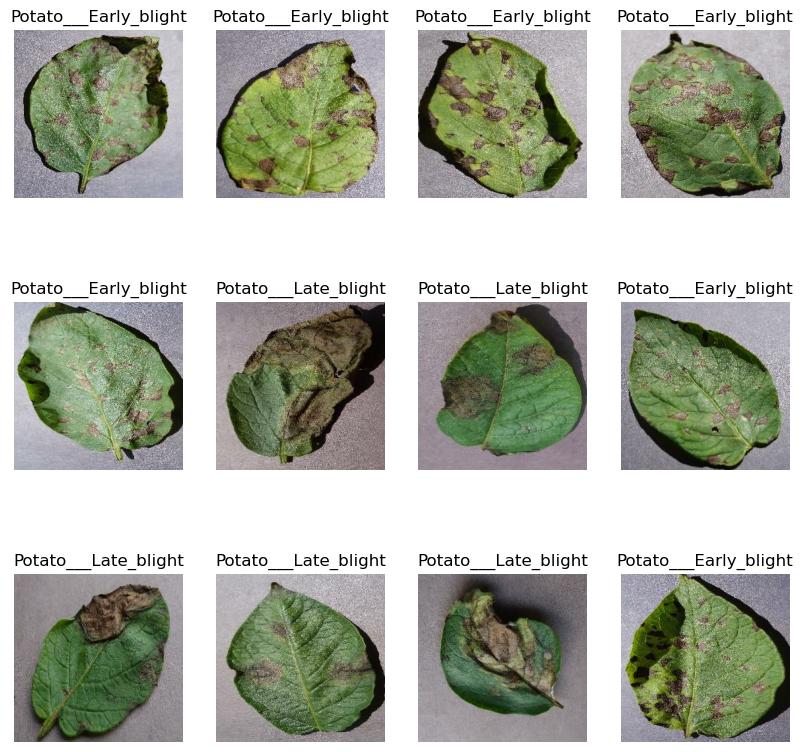

In [7]:
# Lets say i want to visualize this image
# :  Its a matlpotilb plot : plt.imshow() : imshow it expects 3d array 
# 1_batch = 32 images ,
plt.figure(figsize=(10,10)) # area blw the all the leaves
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        # Subplot (3,4) like matrix
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

###### Now we are going to splits our date set


#80% ==> training

#20% ==> 10% validation,10% test

Validaton set will be used during the training process on when you run each epoch afer each we do validation on this 10%. At the end of every epoch we use this validation data set to do the validation.

=> Once we are done througth 20 epochs, Onces we have final model then we use this 10% test dateset to measure the accuracy of our model

=> Before we deploy our model into the wild , we want to use this 10% test data set to test the performances of our model.

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
# ds =dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
# Now what we done about split date. { now we are showing in python function call it}
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        # Seed is just for predictability seed it can be any number .
    
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

# Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

###### Now my these data sets are kind of optimizes for training preformance . So then training will run fast 

# Building the Model

### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [21]:
# preprocessing --> rescaling 
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

#### We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.build(input_shape=input_shape)


## Part 1 :
#### (A) Convolution Layer

tf.keras.layers.Conv2D( filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1),
    groups=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
    kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
    **kwargs
)

#### filters :
###### No of filters  --> One filter could be to detect eye ,One filter could be to detect noise ..like that --> 32 layers  i am taking trial and error in project.
###### Next layer --> 64 layer --> that i am taking trial and error.                        

#####  kernel_size : 
###### Basically size of the filters --> 3 by 3 -->  (3 , 3)

##### Then coming to Activation layer :  
###### the popular activation layer for hidden layer is always 'relu' because its very fast to compute 

###### Input_shape -->
###### its 255 by 255 --> (Image_size , Image_size) --> (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) 
#### (B) Pooling Layer : 

###### Here i want max pooling layer of size 2d .
###### Max pooling 2 by 2 filter with stride = 2
###### Before i tired maybe i need to stack few max pooling and convert 2d layers  --Total -( 6 )

### Part 2
##### 1.  layers.Flatten --> Flattren layer 
##### 2.Dense layer 
##### 3. Last layer will have three neurons with soft max activation functon
###### Soft max activation function is it will normalize the probability os your classes 


### Last :  Model_ Input
##### model.build(input_shape=input_shape)


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 62, 62, 32)          11648     
                                                                 
 max_pooling2d (MaxPooling2D  (32, 30, 30, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 30, 30, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 14, 14, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 14, 14, 64)         

##### These paremetes are weights -->( total params : 183 , 747 ) that we need to train thats y  its tells trianable parameter . 

###### ---> You know that here doing back propagation on all this .

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

##### About matric  : matric in each epoch .--> what tyoe of matric will you use to track the gradient descent .
#####  Accuracy  is the metric that we use to kind of track the training process .

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 13s 226ms/step - loss: 0.9313 - accuracy: 0.4606 - val_loss: 0.7823 - val_accuracy: 0.4583
Epoch 2/50
54/54 [==============================] - 10s 191ms/step - loss: 0.9151 - accuracy: 0.5012 - val_loss: 0.7765 - val_accuracy: 0.5260
Epoch 3/50
54/54 [==============================] - 10s 193ms/step - loss: 0.7646 - accuracy: 0.6140 - val_loss: 0.4011 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 11s 197ms/step - loss: 0.5035 - accuracy: 0.7847 - val_loss: 0.3290 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 10s 187ms/step - loss: 0.3381 - accuracy: 0.8600 - val_loss: 0.2245 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 10s 182ms/step - loss: 0.2891 - accuracy: 0.8825 - val_loss: 0.1858 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 10s 192ms/step - loss: 0.2581 - accuracy: 0.8924 - val_loss: 0.1568 - val_accuracy: 0.9323

##### verbose = one --> so that it just prints lots of ouput and we can see , what's going on 
###### validation data -->  so this validation used in during the each epoch it can help you track the accuracy

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 49ms/step - loss: 0.0475 - accuracy: 0.9805


##### Before deploy any model ,
###### I want to run a test , I want to figure out how well your model  is performing by trying it out on a test data set. So that its not biased. my model has not seen this data set . This is the first time we are trying it  and it can give us good understanding.

### Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

##### loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9313121438026428,
 0.9151238799095154,
 0.7646086812019348,
 0.5034642219543457,
 0.33808520436286926]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Plt training Vs Validation Accuracy

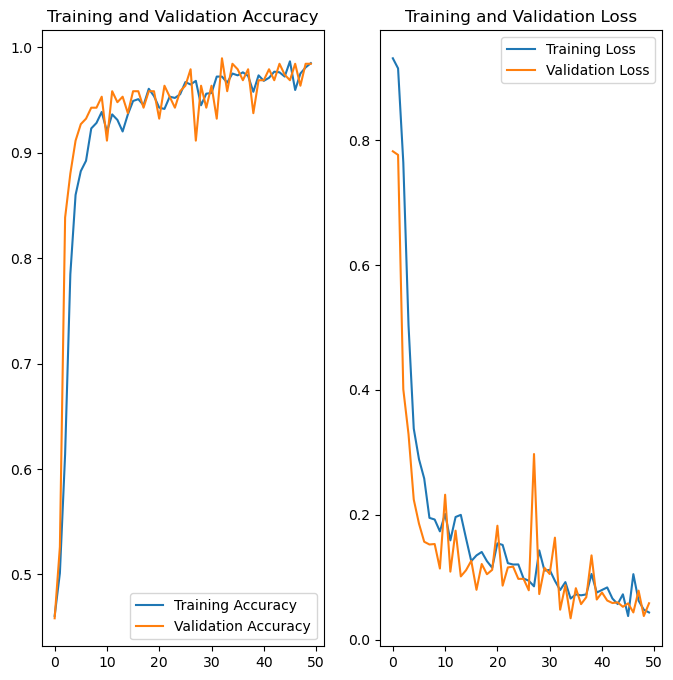

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 141ms/step
predicted label: Potato___Late_blight


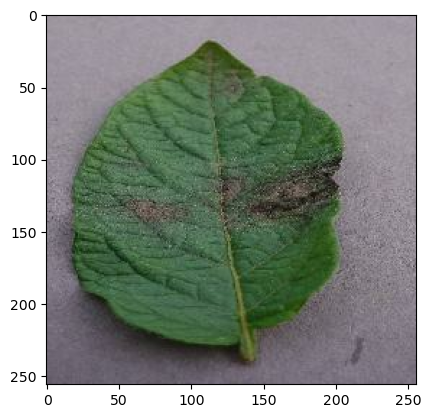

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
     #---->  PLTING CONVERTING numpy to image formation
    plt.imshow(first_image)  
     #  --> its actual label 
    print("actual label:",class_names[first_label]) 
     #--> its predictions label
    batch_prediction = model.predict(images_batch) # --> In batches 
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) 
    # np.argmax(batch_prediction[0] --> 3d to index of image   

### Write a function for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


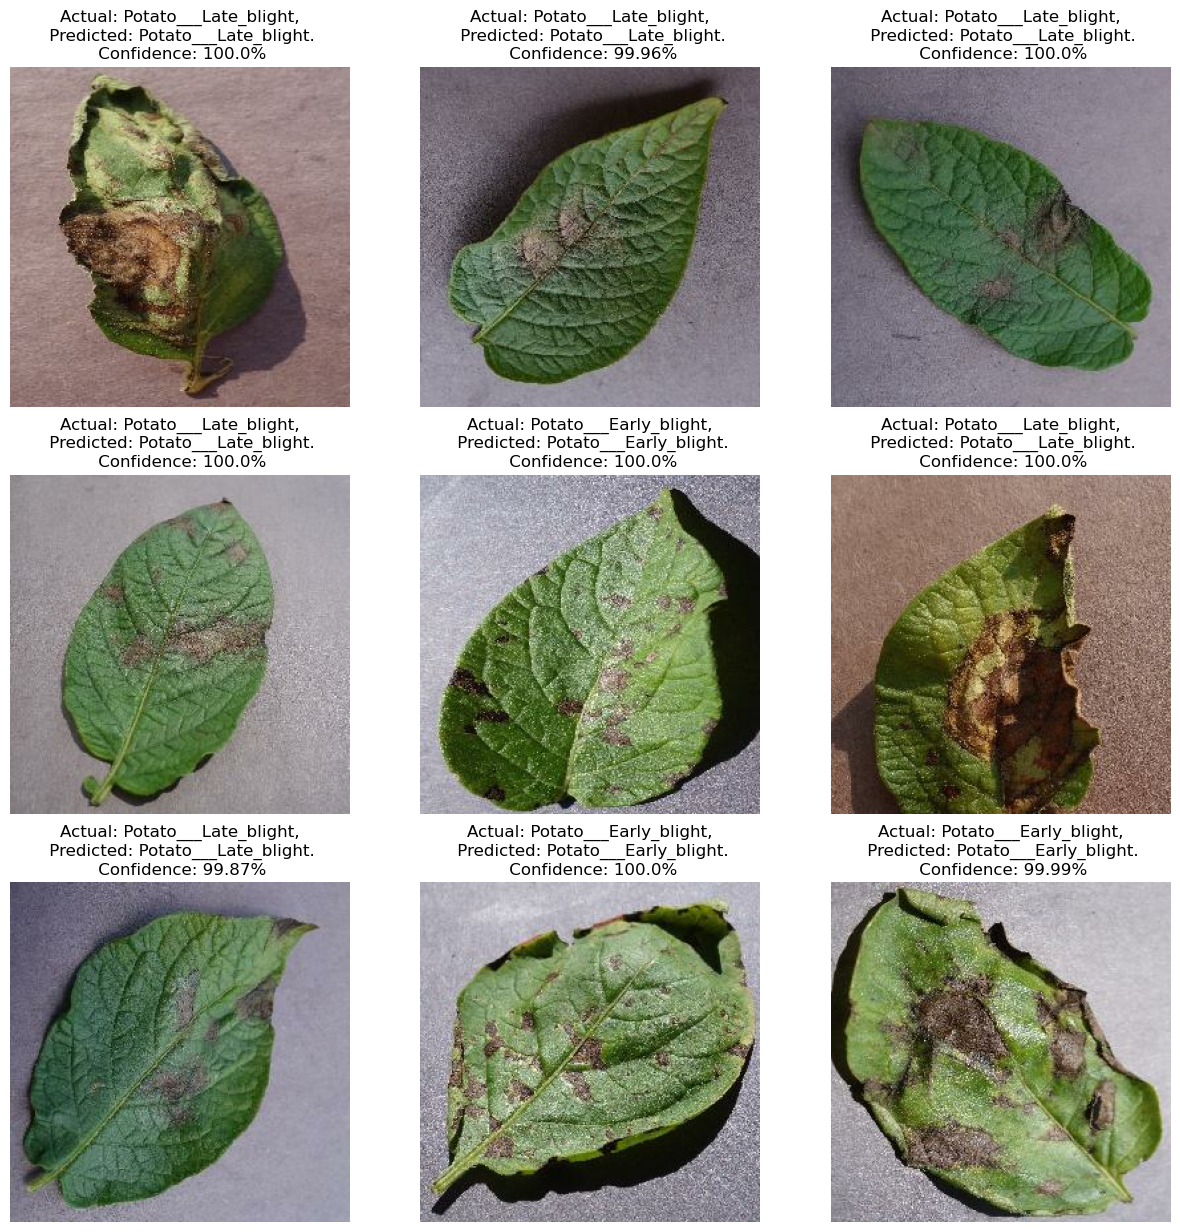

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
model_version=1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1/assets


INFO:tensorflow:Assets written to: ../model/1/assets
